In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


## La Serie


In [ ]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

tf.random.set_seed(123)

# Leer el archivo Excel y parsear la fecha
df = pd.read_excel("../Datos Originales/Consumo.xlsx")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

# Filtrar únicamente la columna de Diesel alto azufre
serie = df[["Diesel alto azufre"]].dropna()

print('\n Datos parseados:')
serie.head()


 Datos parseados:


,Diesel alto azufre
Fecha,
2000-01-01,634667.06
2000-02-01,642380.66
2000-03-01,699807.25
2000-04-01,586803.98
2000-05-01,656948.20


A continuación podemos ver el gráfico de la serie. 

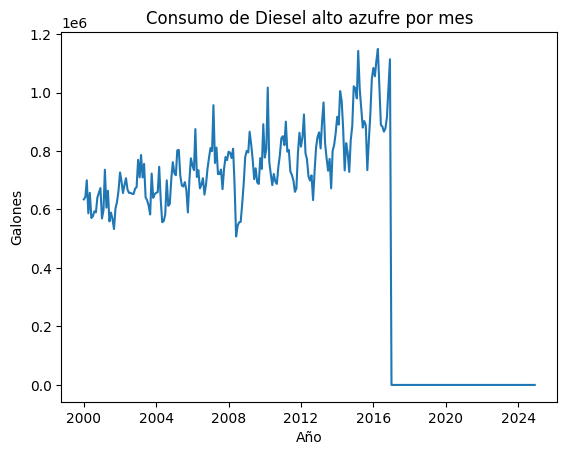

In [6]:
plt.plot(serie)
plt.gca().set(title="Consumo de Diesel alto azufre por mes", xlabel="Año", ylabel="Galones")
plt.show()

(Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media)

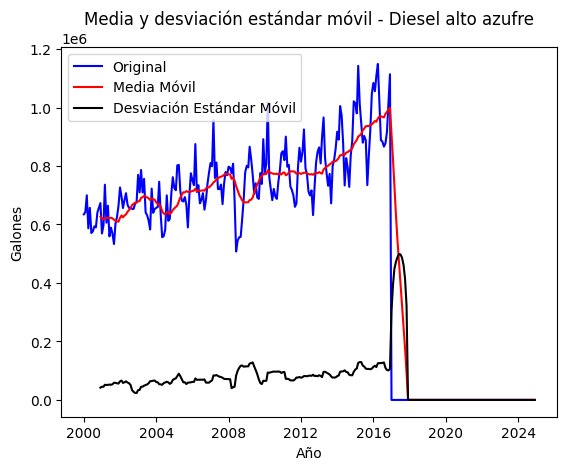

In [7]:
# Calcular media móvil y desviación estándar móvil de los últimos 12 meses
mediaMovil = serie.rolling(window=12).mean()
deMovil = serie.rolling(window=12).std()

# Graficar resultados
plt.plot(serie, color="blue", label="Original")
plt.plot(mediaMovil, color='red', label='Media Móvil')
plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y desviación estándar móvil - Diesel alto azufre')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.show()

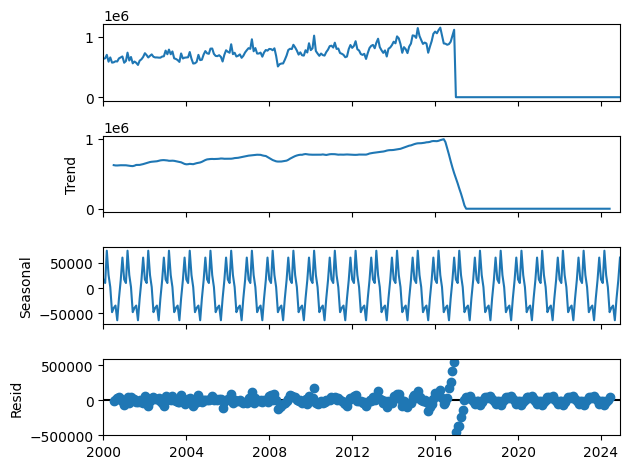

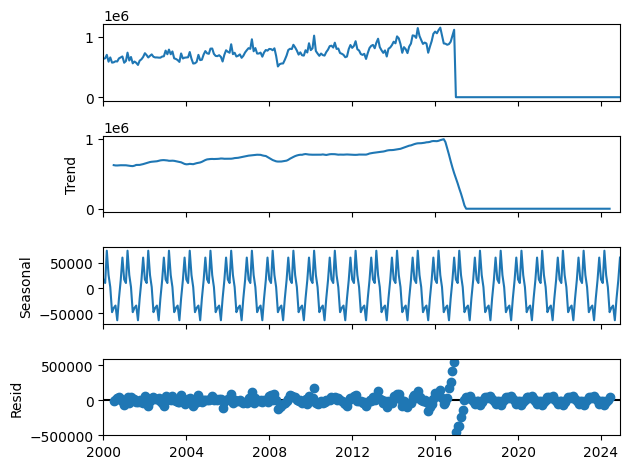

In [8]:
descomposicion = seasonal_decompose(serie)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [9]:
from statsmodels.tsa.stattools import adfuller

print('Resultados del Test de Dickey-Fuller para Diesel alto azufre')
dfTest = adfuller(serie["Diesel alto azufre"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf[f'Valor crítico ({key})'] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para Diesel alto azufre
Estadístico de prueba         -0.901169
p-value                        0.787587
# de retardos usados           6.000000
# de observaciones usadas    293.000000
Valor crítico (1%)            -3.452867
Valor crítico (5%)            -2.871455
Valor crítico (10%)           -2.572053
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [10]:
print('Resultados del Test de Dickey-Fuller para una diferenciación de la serie Diesel alto azufre')

# Diferenciar la serie
serie_diff = serie["Diesel alto azufre"].diff()
serie_diff.fillna(0, inplace=True)

# Prueba de Dickey-Fuller sobre la serie diferenciada
dfTest = adfuller(serie_diff)
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf['Valor crítico (%s)' % key] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para una diferenciación de la serie Diesel alto azufre


Estadístico de prueba       -9.451944e+00
p-value                      4.591291e-16
# de retardos usados         5.000000e+00
# de observaciones usadas    2.940000e+02
Valor crítico (1%)          -3.452790e+00
Valor crítico (5%)          -2.871422e+00
Valor crítico (10%)         -2.572035e+00
dtype: float64


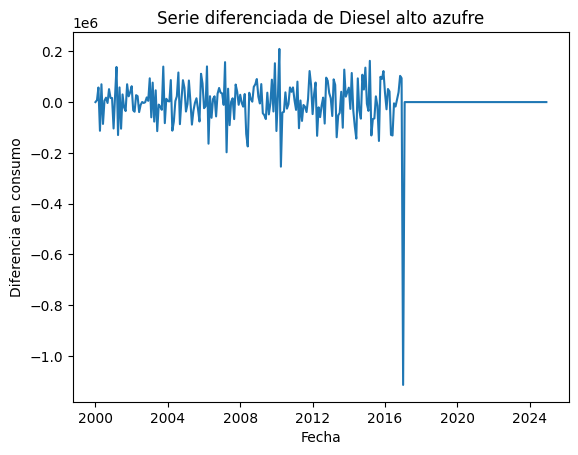

In [11]:
plt.plot(serie_diff)
plt.title("Serie diferenciada de Diesel alto azufre")
plt.xlabel("Fecha")
plt.ylabel("Diferencia en consumo")
plt.show()

Como ya han podido explorarlo, las redes neuronales (como LSTM) son sensibles a la escala de los datos. Si hay valores grandes, junto con pequeños, la red puede tener dificultades al aprender, especialmente usando funciones de activación como tanh o sigmoid. (Además que esto facilita el entrenamiento). 

Como las redes neuronales trabajan mejor con los datos normalizados, vamos a normalizar la serie. 

Al normalizarla, estamos haciendo que la data tenga una media de 0 y una desviación estándar de 1. 

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
serie_diff_scaled = scaler.fit_transform(serie_diff.values.reshape(-1, 1))
serie_diff_scaled[:6]

array([[ 0.02384607],
       [ 0.11079201],
       [ 0.67114547],
       [-1.24990096],
       [ 0.81449569],
       [-0.94584549]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [13]:
# Largo total de la serie
total_len = len(serie_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = serie_diff_scaled[:train_end]
validation = serie_diff_scaled[train_end:val_end]
test = serie_diff_scaled[val_end:]

# Redimensionar para modelos tipo LSTM
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [14]:
train, type(train)

(array([[ 0.02384607],
        [ 0.11079201],
        [ 0.67114547],
        [-1.24990096],
        [ 0.81449569],
        [-0.94584549],
        [ 0.08602274],
        [ 0.21923941],
        [-0.01701827],
        [ 0.59834527],
        [ 0.2038894 ],
        [ 0.20640323],
        [-1.14789372],
        [ 0.3442016 ],
        [ 1.58313945],
        [-1.43954902],
        [ 0.67563624],
        [-1.15686775],
        [ 0.36334846],
        [-0.21180564],
        [-0.37560274],
        [ 0.81583219],
        [ 0.28067339],
        [ 0.45255663],
        [ 0.72813357],
        [-0.34054573],
        [-0.40409225],
        [ 0.33119211],
        [ 0.28895025],
        [-0.41963907],
        [-0.10080969],
        [ 0.02765751],
        [-0.01487404],
        [ 0.0169553 ],
        [ 0.23066121],
        [ 0.07785048],
        [ 1.07945706],
        [-0.65313337],
        [ 0.8884012 ],
        [-0.84248089],
        [ 0.54635651],
        [-1.26611766],
        [-0.08702262],
        [-0

In [15]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


In [16]:
x_train

array([[ 0.02384607],
       [ 0.11079201],
       [ 0.67114547],
       [-1.24990096],
       [ 0.81449569],
       [-0.94584549],
       [ 0.08602274],
       [ 0.21923941],
       [-0.01701827],
       [ 0.59834527],
       [ 0.2038894 ],
       [ 0.20640323],
       [-1.14789372],
       [ 0.3442016 ],
       [ 1.58313945],
       [-1.43954902],
       [ 0.67563624],
       [-1.15686775],
       [ 0.36334846],
       [-0.21180564],
       [-0.37560274],
       [ 0.81583219],
       [ 0.28067339],
       [ 0.45255663],
       [ 0.72813357],
       [-0.34054573],
       [-0.40409225],
       [ 0.33119211],
       [ 0.28895025],
       [-0.41963907],
       [-0.10080969],
       [ 0.02765751],
       [-0.01487404],
       [ 0.0169553 ],
       [ 0.23066121],
       [ 0.07785048],
       [ 1.07945706],
       [-0.65313337],
       [ 0.8884012 ],
       [-0.84248089],
       [ 0.54635651],
       [-1.26611766],
       [-0.08702262],
       [-0.18215198],
       [-0.31925628],
       [ 1

In [17]:
y_train, type(y_train)

(array([ 0.11079201,  0.67114547, -1.24990096,  0.81449569, -0.94584549,
         0.08602274,  0.21923941, -0.01701827,  0.59834527,  0.2038894 ,
         0.20640323, -1.14789372,  0.3442016 ,  1.58313945, -1.43954902,
         0.67563624, -1.15686775,  0.36334846, -0.21180564, -0.37560274,
         0.81583219,  0.28067339,  0.45255663,  0.72813357, -0.34054573,
        -0.40409225,  0.33119211,  0.28895025, -0.41963907, -0.10080969,
         0.02765751, -0.01487404,  0.0169553 ,  0.23066121,  0.07785048,
         1.07945706, -0.65313337,  0.8884012 , -0.84248089,  0.54635651,
        -1.26611766, -0.08702262, -0.18215198, -0.31925628,  1.59934813,
        -0.91098066,  0.17087574,  0.07022885,  0.05262324,  1.0010682 ,
        -1.24389886, -0.84854801,  0.0692012 ,  0.27977239,  1.33714558,
        -0.95647376,  0.09649512,  0.99562348,  0.66144668, -0.39514754,
        -0.06154425,  0.98220376,  0.0447817 , -0.97524419, -0.35507797,
        -0.01142206,  0.19367402, -0.28525701, -0.8


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote (batch), también conocido como tamaño del lote (batch size).
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones
(n_samples, time_steps, n_features)

In [18]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [19]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

LSTM(units, input_shape=(pasos, características), stateful=False)
- units: cantidad de neuronas. Cada una es como una "mini-memoria" que puede aprender patrones en secuencias.
- input_shape: pasos (lags) y features (cant de variables)
- batch_input_shape: Solo se usa si stateful=True. Igual que input_shape, pero le agregas el tamaño fijo del batch (batch_size). O sea: (batch_size, pasos, características).
- stateful: mantiene el estado (memoria) entre batches, ayuda para entender dependencias a largo plazo entre batches

Dense(1)
#
- Toma lo que sale de la LSTM y le aplica una transformación lineal con pesos y bias.
- En este caso, Dense(1) significa: produce una sola salida (por ejemplo, una predicción de un número, como el siguiente valor de la serie).

In [20]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [21]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las epochs(épocas) que es la cantidad de iteraciones. Lo pondremos en 50.

In [22]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.5520 - val_loss: 3.0241
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5369 - val_loss: 3.0195
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5257 - val_loss: 3.0145
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5167 - val_loss: 3.0094
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5092 - val_loss: 3.0040
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5030 - val_loss: 2.9988
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4977 - val_loss: 2.9938
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4931 - val_loss: 2.9894
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4891 - val_loss: 2.9855
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4856 - val_loss: 2.9821
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4824 - val_loss: 2.9792
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

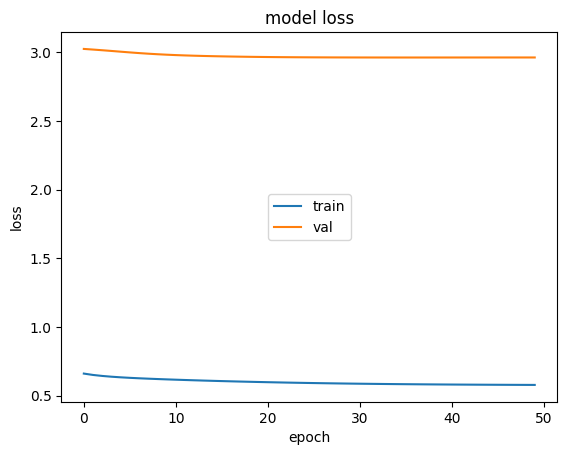

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [24]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4825 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.7854
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0337


0.03366684541106224

Ahora vamos a predecir con el modelo 1.  

In [25]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val1 = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test1 = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))


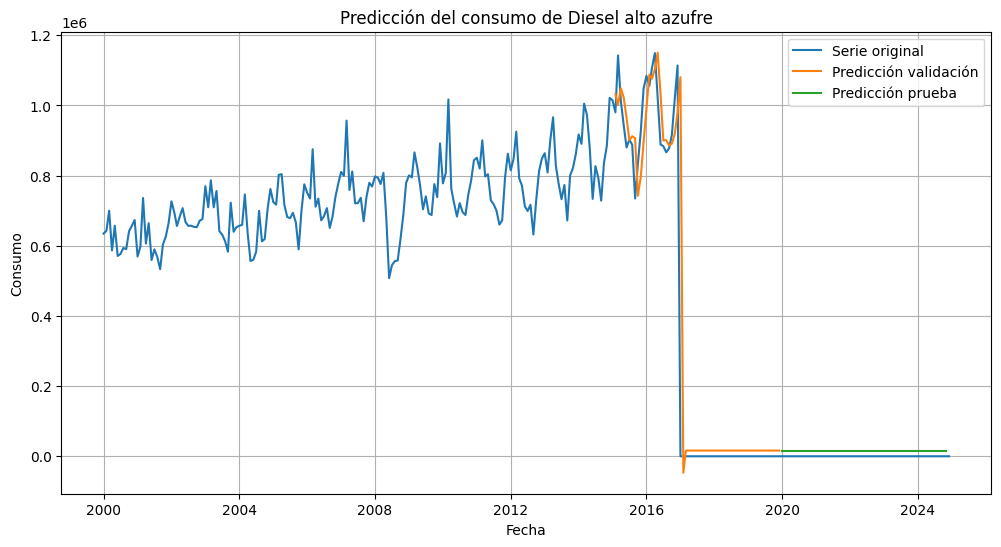

In [26]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val1, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test1, index=serie[val_end:].index[:len(prediccion_test1)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de Diesel alto azufre')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()



### Modelo 2

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Parámetros
unidades = 50
paso = 12
caracteristicas = 1

# Crear el modelo
modelo2 = Sequential()

# Capa LSTM con más unidades
modelo2.add(LSTM(
    units=100,  # Más unidades en la primera capa
    return_sequences=True,  # Necesario para apilar otra capa LSTM
    input_shape=(paso, caracteristicas),
    stateful=False
))
modelo2.add(Dropout(0.3))  # Regularización más fuerte

# Segunda capa LSTM
modelo2.add(LSTM(
    units=50,  # Más unidades en la segunda capa
    stateful=False
))
modelo2.add(Dropout(0.3))  # Regularización

# Capa de salida
modelo2.add(Dense(1))  # Predicción

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)  # Ajuste de la tasa de aprendizaje
modelo2.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del modelo con EarlyStopping
modelo2.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluar el rendimiento del modelo
prediccion_test2 = modelo2.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, prediccion_test2))
print(f'RMSE: {rmse}')


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - loss: 0.7248 - val_loss: 4.8874e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7191 - val_loss: 2.0913e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7155 - val_loss: 3.6717e-05
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7076 - val_loss: 6.1505e-06
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7031 - val_loss: 1.1999e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6936 - val_loss: 3.4337e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6919 - val_loss: 5.9709e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.6838 - val_loss: 8.5883e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6748 - val_loss: 0.0011
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6712 - val_loss: 0.0015
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6665 - val_loss: 0.0018
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [28]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [29]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5352 - val_loss: 3.0242
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5115 - val_loss: 3.0139
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5035 - val_loss: 3.0101
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4932 - val_loss: 3.0047
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4915 - val_loss: 3.0020
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4799 - val_loss: 2.9885
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4852 - val_loss: 2.9893
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4727 - val_loss: 2.9852
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4699 - val_loss: 2.9800
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4758 - val_loss: 2.9807
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4742 - val_loss: 2.9827
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 

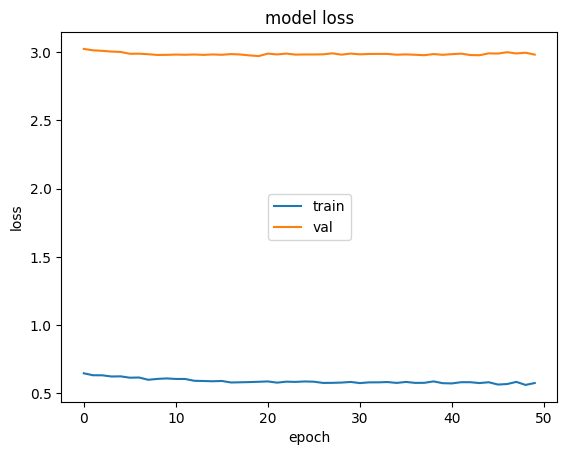

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [31]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4867  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.8151
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0218


0.021770643070340157

In [32]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))

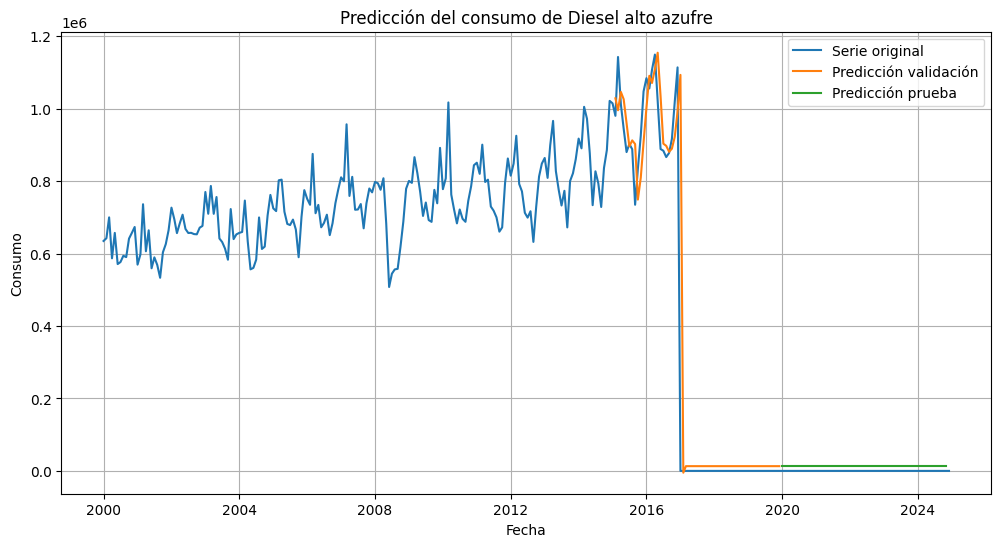

In [33]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val2, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test2, index=serie[val_end:].index[:len(prediccion_test2)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de Diesel alto azufre')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

In [34]:
# --- Modelo 1 ---
rmse_val_1 = np.sqrt(mean_squared_error(y_val, prediccion_val1))
rmse_test_1 = np.sqrt(mean_squared_error(y_test, prediccion_test1))

# --- Modelo 2 ---
rmse_val_2 = np.sqrt(mean_squared_error(y_val, prediccion_val2))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, prediccion_test2))

# Mostrar resultados
print(f"Modelo 1 - RMSE validación: {rmse_val_1:.2f} | RMSE prueba: {rmse_test_1:.2f}")
print(f"Modelo 2 - RMSE validación: {rmse_val_2:.2f} | RMSE prueba: {rmse_test_2:.2f}")


Modelo 1 - RMSE validación: 620284.88 | RMSE prueba: 16278.27
Modelo 2 - RMSE validación: 621661.05 | RMSE prueba: 13090.09


Nos importa mas el RMSE de prueba

## Conclusión

Para el consumo de diésel bajo azufre, el modelo LSTM logró capturar la tendencia general, pero enfrentó dificultades al ajustarse a las fluctuaciones mensuales abruptas de la serie. Aun así, ofreció un mejor desempeño que los modelos del laboratorio anterior (ARIMA y Prophet), que no lograron representar adecuadamente la variabilidad del consumo. Esto resalta el valor de los modelos LSTM en contextos donde los patrones no son estrictamente lineales ni estacionales, ya que su arquitectura permite adaptarse a series más ruidosas y dinámicas.
